# Barock & Realismus

In [19]:
import argparse
from collections import Counter, defaultdict
from datetime import datetime
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, completeness_score, homogeneity_score, v_measure_score
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, Normalizer


from stop_words import get_stop_words
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.append('../')
from utils import add_epoch_division, clear_json, merge_corpus_poets, text_cleaning
from yellowbrick.text import UMAPVisualizer

In [72]:
corpus = text_cleaning(pd.read_csv("../../corpora/german_poems.csv"))


with open("../epochs.json") as f:
    epochs = json.loads(f.read())
    
epochs = epochs["brenner"]

split_barock = False
if split_barock:
    del epochs["Barock"]
    epochs["Frühbarock"] = {"b": 1600, "e": 1650}
    epochs["Hochbarock"] = {"b": 1650, "e": 1700}
    epoch1 = "Frühbarock"
    epoch2 = "Hochbarock"
    epoch3 = "Realismus"
    k = 3
else:
    epoch1 = "Barock"
    epoch2 = "Realismus"
    k = 2

epoch_exception = "Klassik_Romantik"

corpus = add_epoch_division(corpus, epochs, epoch_exception=epoch_exception)
corpus = merge_corpus_poets(corpus)

In [73]:
if split_barock:
    corpus = corpus[(corpus.epoch == epoch1) | (corpus.epoch == epoch2) | (corpus.epoch == epoch3)]
else:
    corpus = corpus[(corpus.epoch == epoch1) | (corpus.epoch == epoch2)]

In [75]:
text = corpus["poem"].values
labels = LabelEncoder().fit_transform(corpus["epoch"].values)
unique_epochs = list(np.unique(corpus["epoch"]))

vectorizer = TfidfVectorizer(max_df=0.5,
                             lowercase=True,
                             max_features=10000,
                             stop_words=get_stop_words("de"))

vector = vectorizer.fit_transform(text)

In [76]:
kmeans = KMeans(k)
kmeans.fit(vector)
centroids = kmeans.cluster_centers_
kmeans_ari = adjusted_rand_score(labels, kmeans.labels_)
kmeans_vm = v_measure_score(labels, kmeans.labels_)
print(f"ARI: {kmeans_ari}")
print(f"VM: {kmeans_vm}")

ARI: 0.843127545525446
VM: 0.7812051699733796


### insights

In [77]:
corpusl = corpus.copy()
corpusl["cluster"] = kmeans.labels_

In [78]:
corpusl.sample(10)

,id,poet,poem,year,epoch,cluster
20,20,"Busch, Wilhelm",Ein Herr warf einem Bettelmann Fünf Groschen i...,1869,Realismus,1
95,95,"Hofmannsthal, Hugo von",Der Schatten eines Toten fiel auf uns Und eine...,1893,Realismus,1
195,195,"Stadler, Ernst","Starr stand er, Den Todespfeil im Herzen, Weiß...",1898,Realismus,1
12,12,"Birken, Sigmund von","O wie wohl ist der daran, Der da kann Sich beg...",1660,Barock,0
141,141,"Morgenstern, Christian",Jahrhunderttausende durchmißt mein Geist ... V...,1892,Realismus,1
179,179,"Scheffel, Joseph Viktor von",Und wieder saß beim Weine Im Waldhorn ob der B...,1856,Realismus,1
86,86,"Hensel, Luise","Wo berg' ich, Herr, die Schätze Deiner Gnade, ...",1857,Realismus,1
80,80,"Harsdörffer, Georg Philipp",Da/ wo der Meisnerbach sich durch die Thäler z...,1632,Barock,0
52,52,"Flaischlen, Cäsar","Laub am Boden, Laub am Boden, gelb und rot und...",1892,Realismus,1
58,58,"George, Stefan",Es lacht in dem steigenden jahr dir Der duft ...,1896,Realismus,1


In [79]:
years = list(corpusl[corpusl.cluster == 1].year.values)

In [80]:
Counter(sorted(years))

Counter({1650: 1,
         1658: 1,
         1660: 1,
         1670: 1,
         1849: 1,
         1852: 2,
         1853: 3,
         1854: 4,
         1855: 4,
         1856: 1,
         1857: 3,
         1859: 3,
         1860: 3,
         1861: 1,
         1862: 2,
         1867: 1,
         1868: 1,
         1869: 2,
         1870: 3,
         1871: 2,
         1873: 1,
         1876: 1,
         1877: 1,
         1878: 1,
         1879: 1,
         1881: 1,
         1882: 3,
         1884: 1,
         1887: 2,
         1889: 1,
         1890: 1,
         1891: 3,
         1892: 3,
         1893: 1,
         1894: 4,
         1896: 2,
         1898: 1,
         1899: 1})

## visualizing

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


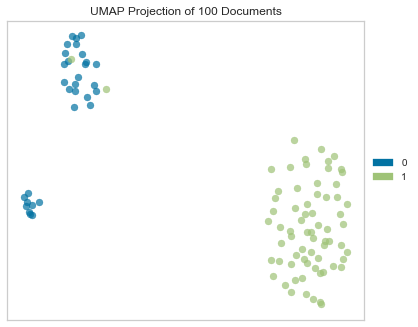

In [83]:
umap = UMAPVisualizer(color="bold")
umap.fit(vector, kmeans.labels_)
#umap.show()
if split_barock:
    umap.show("../../results/figures/Barock_Realismus_three_cluster.png", dpi=300)
else:
    umap.show("../../results/figures/Barock_Realismus_two_cluster.png", dpi=300)

### topic modelling (TODO)

In [68]:
from sklearn.decomposition import LatentDirichletAllocation

realismus = corpus[corpus.epoch == "Realismus"]
vector = vectorizer.fit_transform(realismus.poem)

lda = LatentDirichletAllocation(n_components=20, random_state=0)
lda.fit(vector)

print("\nTopics in LDA model:")
tf_feature_names = vectorizer.get_feature_names()
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
#print_top_words(lda, tf_feature_names, 20)


Topics in LDA model:
